## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import shap

## Data Preparation

In [2]:
df = pd.read_csv('data/Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
X = df.drop(columns=['churn', 'customer_id', 'active_member'])
y = df['churn']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111, shuffle=True, stratify=y)

In [5]:
enc = OneHotEncoder(handle_unknown='ignore', drop='if_binary')
X_train_oh = enc.fit_transform(X_train[['country', 'gender']])
X_test_oh = enc.transform(X_test[['country', 'gender']])

column_name = enc.get_feature_names_out(['country', 'gender'])
X_train_oh = pd.DataFrame(X_train_oh.toarray(), columns=column_name, index=X_train.index)
X_test_oh = pd.DataFrame(X_test_oh.toarray(), columns=column_name, index=X_test.index)

X_train_num =  pd.concat([X_train.drop(columns=['country', 'gender']), X_train_oh], axis=1)
X_test_num =  pd.concat([X_test.drop(columns=['country', 'gender']), X_test_oh], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

In [6]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train_num, y_train, test_size=0.33, random_state=111, shuffle=True, stratify=y_train)

## Train

In [7]:
params = {
    'objective': 'binary:logistic',  # Objective function to optimize, binary logistic regression for binary classification
    'max_depth': 5,                  # Maximum depth of a tree, controls the maximum depth of each tree in the boosting process
    'learning_rate': 0.1,            # Learning rate, controls the step size at each iteration while moving toward a minimum of the loss function
    'subsample': 0.9,                # Subsample ratio of the training instances, fraction of the training data to be used for each boosting iteration
    'colsample_bytree': 0.95,        # Subsample ratio of columns when constructing each tree, fraction of features to consider for each boosting iteration
    'eval_metric': 'auc',            # Evaluation metric, area under the ROC curve (AUC) used to evaluate model performance
    'scale_pos_weight': 3,           # Control the balance of positive and negative weights, useful for imbalanced classes
    'tree_method': 'hist',           # Method used to build trees, 'hist' uses histogram-based algorithm for faster training
    'min_split_loss': 0.1,           # Minimum loss reduction required to make further partition on a leaf node of the tree
    'reg_alpha': 0.01,               # L1 regularization term on leaf weights, adds penalty on leaf weights to prevent overfitting
}

xgb_train = xgb.XGBClassifier(**params)
xgb_train.fit(X_train_2, y_train_2, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=10)

dump_list = xgb_train.get_booster().get_dump()
num_trees = len(dump_list)

clf_xgb = xgb.XGBClassifier(**params, n_estimators=num_trees)
clf_xgb.fit(X_train_num, y_train)

y_pred_dt = clf_xgb.predict(X_test_num)

[0]	validation_0-auc:0.84150


/home/marek/anaconda3/envs/tibia/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-auc:0.86092
[20]	validation_0-auc:0.85952
[30]	validation_0-auc:0.86110
[40]	validation_0-auc:0.85971
[47]	validation_0-auc:0.85864


In [8]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2628
           1       0.51      0.69      0.59       672

    accuracy                           0.80      3300
   macro avg       0.71      0.76      0.73      3300
weighted avg       0.83      0.80      0.81      3300



In [9]:
confusion_matrix(y_test, y_pred_dt)

array([[2189,  439],
       [ 208,  464]])

## SHAP explainer

In [10]:
explainer = shap.TreeExplainer(clf_xgb)

In [11]:
shap_values = explainer.shap_values(X_test_num)

### summary plot

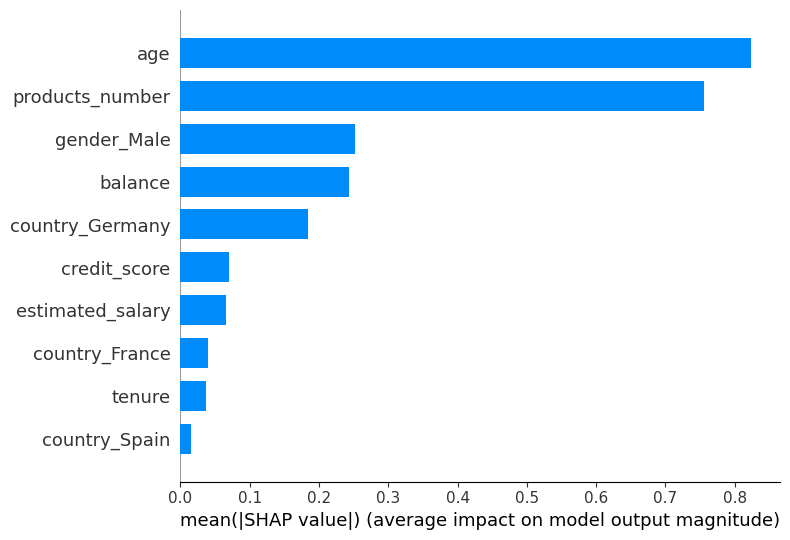

In [12]:
shap.summary_plot(shap_values, features=X_test_num, feature_names=X_test_num.columns, plot_type="bar", max_display=10)

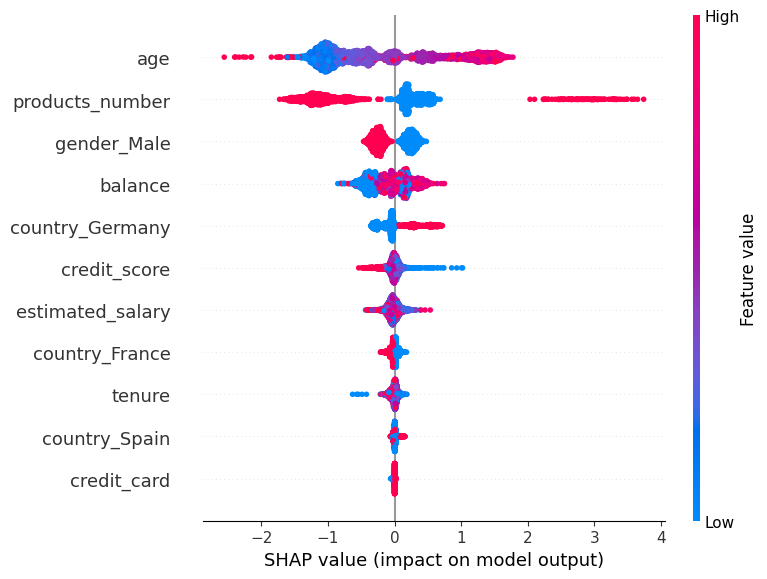

In [13]:
shap.summary_plot(shap_values, X_test_num)

### dependence plot

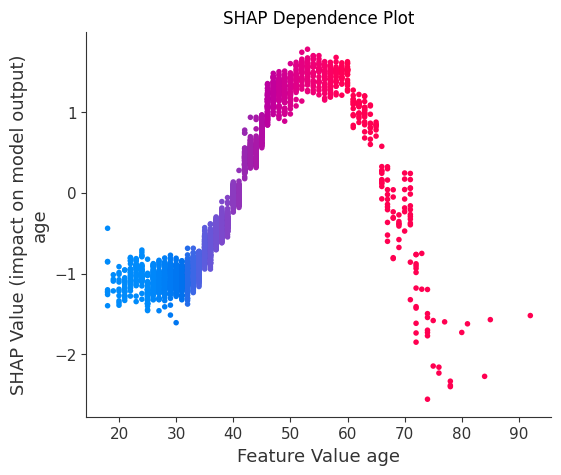

In [14]:
# Visualize dependence plot for a specific feature
feature_name = 'age'  # Specify the feature you want to analyze
shap.dependence_plot(feature_name, shap_values, X_test_num, interaction_index='age', show=False)
plt.title("SHAP Dependence Plot")
plt.xlabel(f"Feature Value {feature_name}")
plt.ylabel(f"SHAP Value (impact on model output)\n{feature_name}")
plt.show()

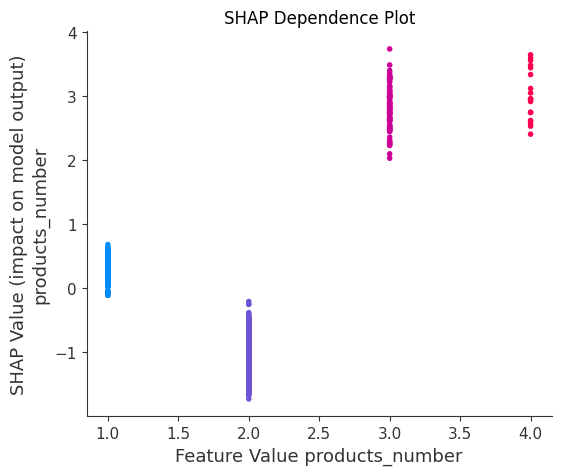

In [15]:
# Visualize dependence plot for a specific feature
feature_name = 'products_number'  # Specify the feature you want to analyze
shap.dependence_plot(feature_name, shap_values, X_test_num, interaction_index='products_number', show=False)
plt.title("SHAP Dependence Plot")
plt.xlabel(f"Feature Value {feature_name}")
plt.ylabel(f"SHAP Value (impact on model output)\n{feature_name}")
plt.show()

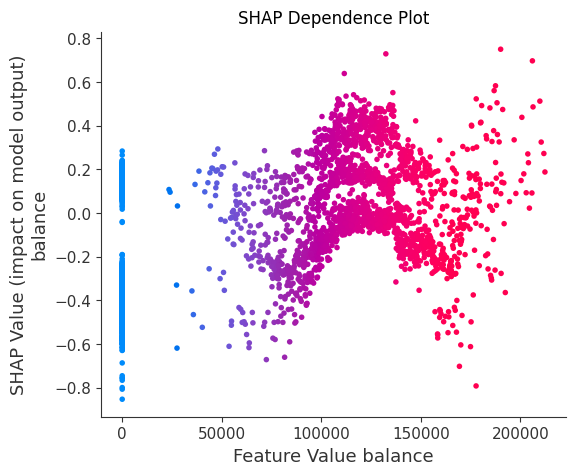

In [16]:
# Visualize dependence plot for a specific feature
feature_name = 'balance'  # Specify the feature you want to analyze
shap.dependence_plot(feature_name, shap_values, X_test_num, interaction_index='balance', show=False)
plt.title("SHAP Dependence Plot")
plt.xlabel(f"Feature Value {feature_name}")
plt.ylabel(f"SHAP Value (impact on model output)\n{feature_name}")
plt.show()

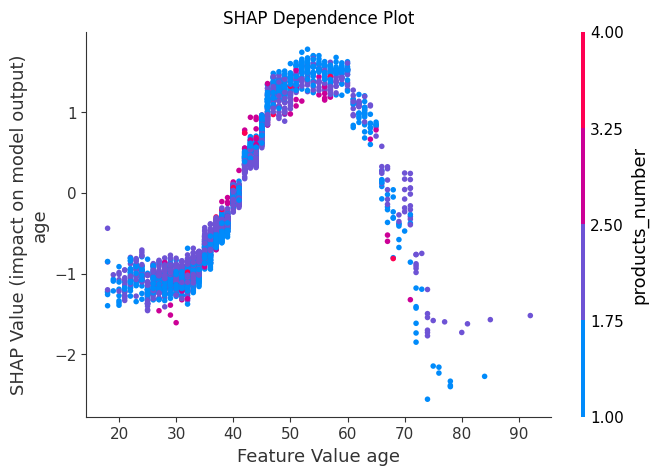

In [17]:
# Visualize dependence plot for a specific feature
feature_name = 'age'  # Specify the feature you want to analyze
shap.dependence_plot(feature_name, shap_values, X_test_num, interaction_index='products_number', show=False)
plt.title("SHAP Dependence Plot")
plt.xlabel(f"Feature Value {feature_name}")
plt.ylabel(f"SHAP Value (impact on model output)\n{feature_name}")
plt.show()
# print("The SHAP dependence plot shows the relationship between the value of a specific feature and the model output. It helps understand how changes in the feature affect the model's predictions.")

### interaction values

In [18]:
shap_interaction_values = explainer.shap_interaction_values(X_test_num)

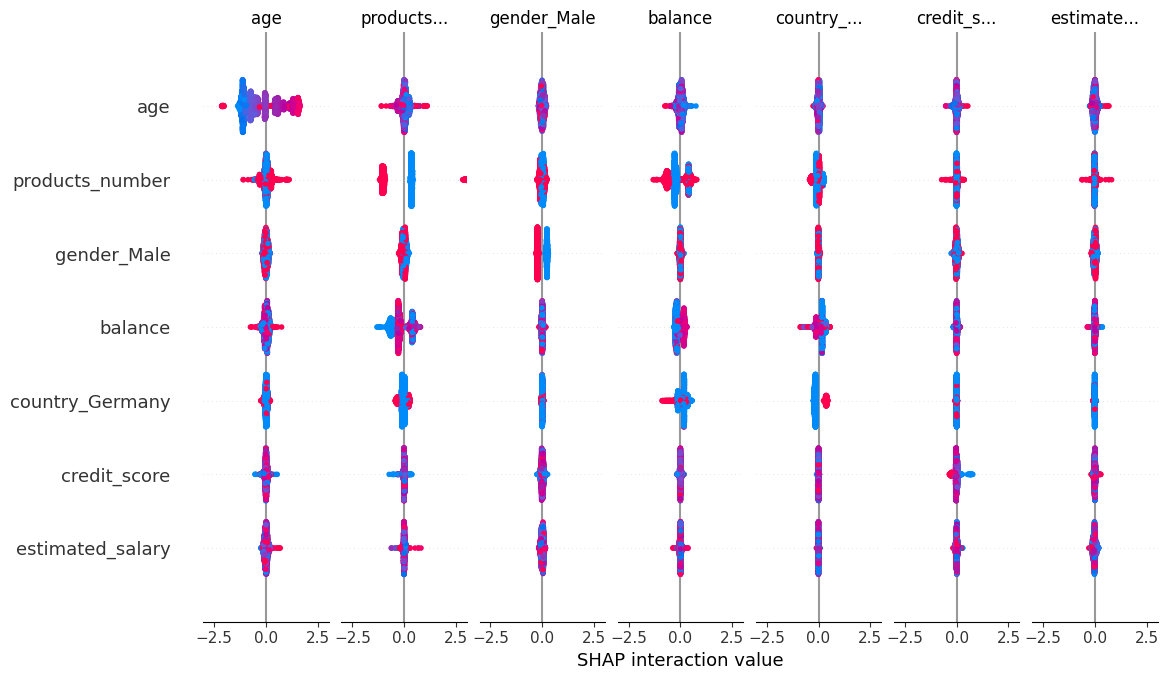

In [19]:
shap.summary_plot(shap_interaction_values, X_test_num)

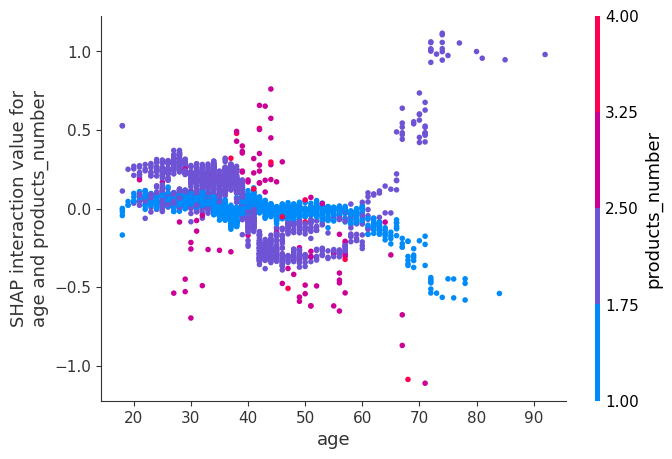

In [20]:
shap.dependence_plot(
    ("age", "products_number"),
    shap_interaction_values, X_test_num,
    display_features=X_test_num
)

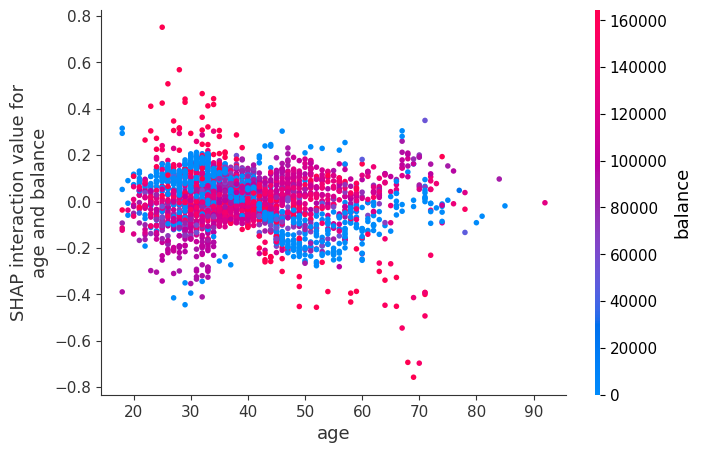

In [21]:
shap.dependence_plot(
    ("age", "balance"),
    shap_interaction_values, X_test_num,
    display_features=X_test_num
)

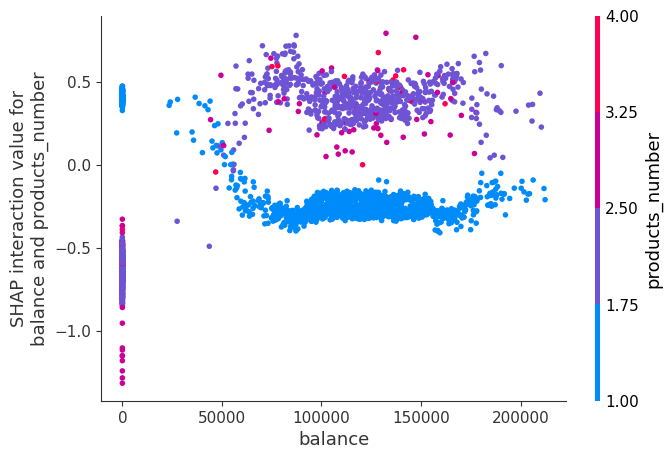

In [23]:
shap.dependence_plot(
    ("balance", "products_number"),
    shap_interaction_values, X_test_num,
    display_features=X_test_num
)

### decision plot

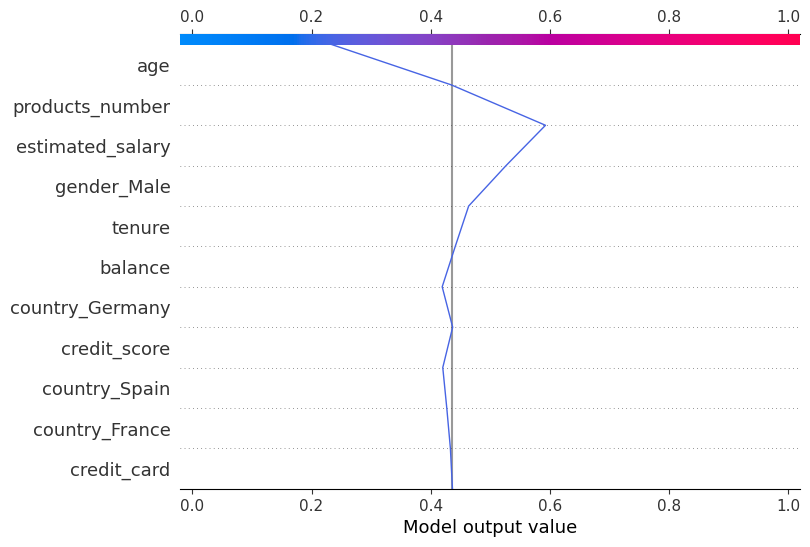

In [24]:
row = 1
shap.decision_plot(explainer.expected_value, shap_values[row], X_test_num.columns, link="logit")

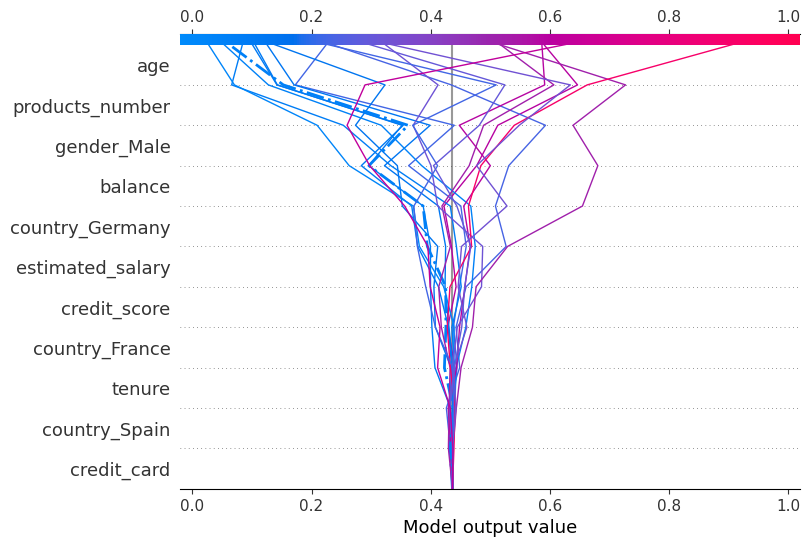

In [25]:
shap.decision_plot(explainer.expected_value, shap_values[:20], X_test_num.columns, link="logit", ignore_warnings=True, highlight=10)

### waterfall plot

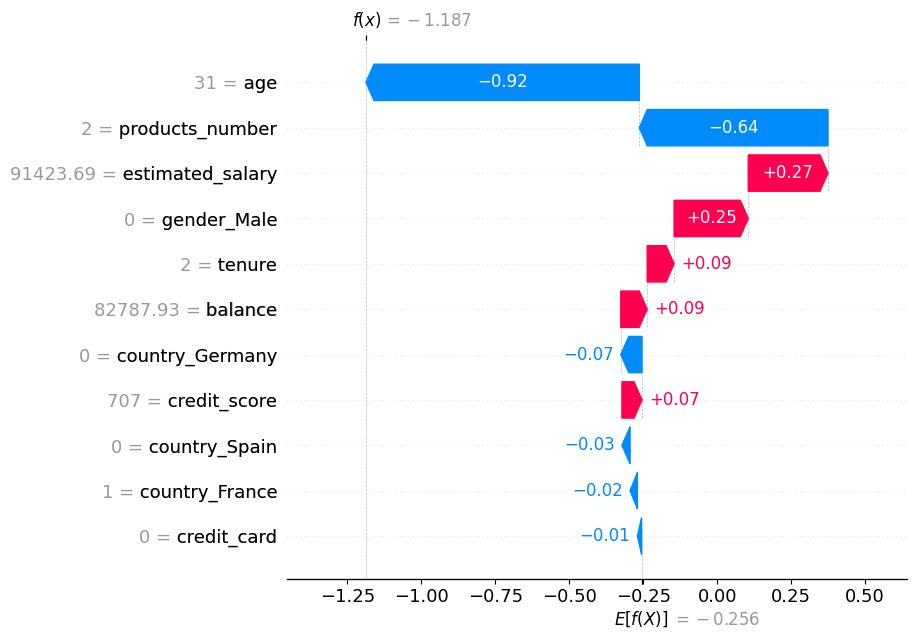

In [26]:
# SHAP waterfall plot - The waterfall plot is another local analysis plot of a single instance prediction.
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[row], 
        base_values=explainer.expected_value, 
        data=X_test_num.iloc[row],  
        feature_names=X_test_num.columns.tolist()
    ),
    max_display=25
)

### force plot

In [27]:
shap.initjs()
# shap_values = explainer.shap_values(X_test_num)

explanation = explainer(X_test_num.sample(330))
shap.plots.force(explanation)

## Examine few examples

In [28]:
# Get predicted probabilities for all examples in the test set
all_predicted_probabilities = clf_xgb.predict_proba(X_test_num)

# Get predicted classes for all examples in the test set
all_predictions = clf_xgb.predict(X_test_num)

y_test_all = pd.DataFrame(y_test).reset_index()
y_test_all['pred'] = all_predictions
y_test_all['proba'] = all_predicted_probabilities[:,1]

correct_1_max = y_test_all[
    (y_test_all['churn']==y_test_all['pred'])
    & (y_test_all['churn']==1)
]['proba'].idxmax()

correct_1_min = y_test_all[
    (y_test_all['churn']==y_test_all['pred'])
    & (y_test_all['churn']==1)
]['proba'].idxmin()

correct_0_max = y_test_all[
    (y_test_all['churn']==y_test_all['pred'])
    & (y_test_all['churn']==0)
]['proba'].idxmax()

correct_0_min = y_test_all[
    (y_test_all['churn']==y_test_all['pred'])
    & (y_test_all['churn']==0)
]['proba'].idxmin()

incorrect_0_max = y_test_all[
    (y_test_all['churn']!=y_test_all['pred'])
    & (y_test_all['churn']==0)
]['proba'].idxmax()

incorrect_1_min = y_test_all[
    (y_test_all['churn']!=y_test_all['pred'])
    & (y_test_all['churn']==1)
]['proba'].idxmin()

selected_examples = [
    correct_1_max,
    correct_1_min,
    incorrect_1_min,
    correct_0_max,
    correct_0_min,
    incorrect_0_max
]

CORRECT PREDICTION
True value 1, predicted probab 0.99


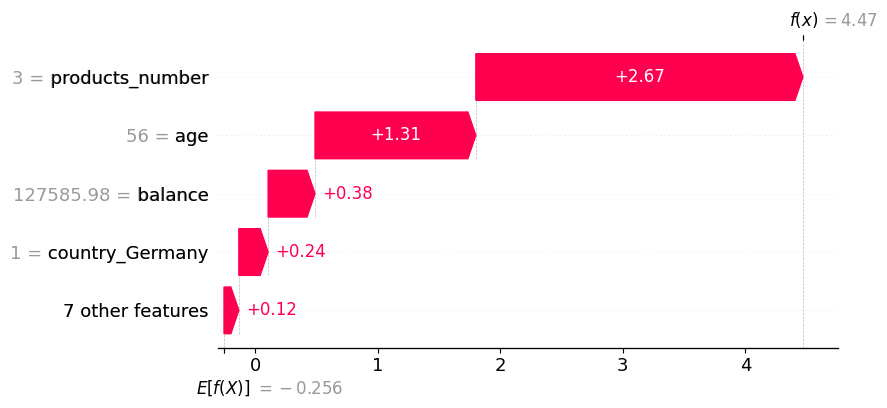

CORRECT PREDICTION
True value 1, predicted probab 0.50


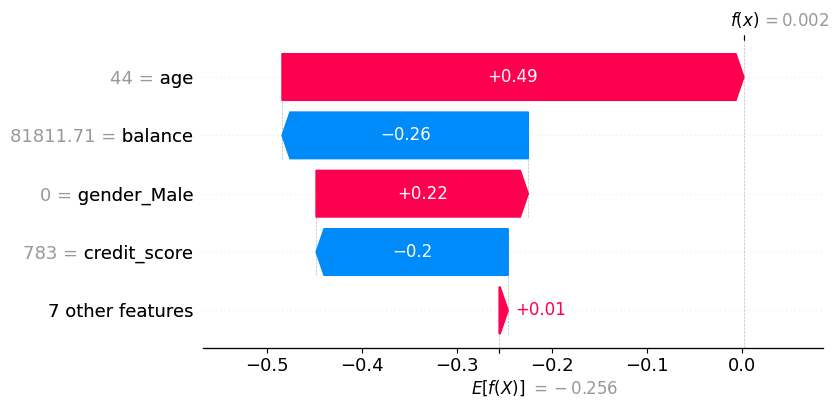

INCORRECT PREDICTION
True value 1, predicted probab 0.04


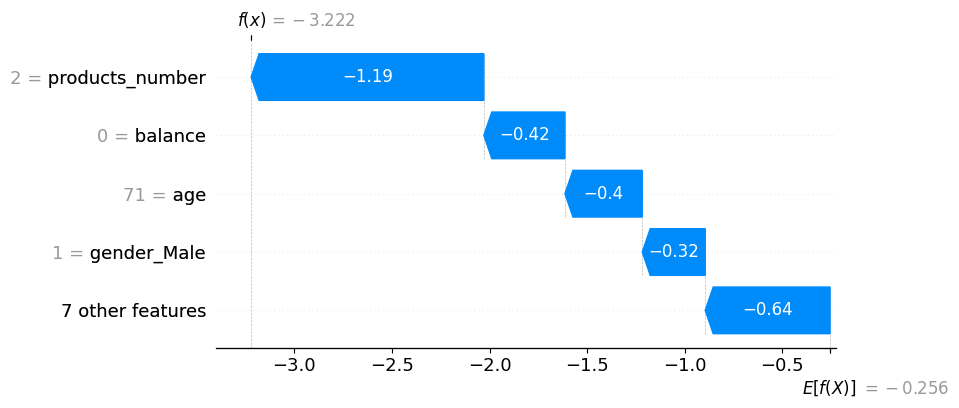

CORRECT PREDICTION
True value 0, predicted probab 0.50


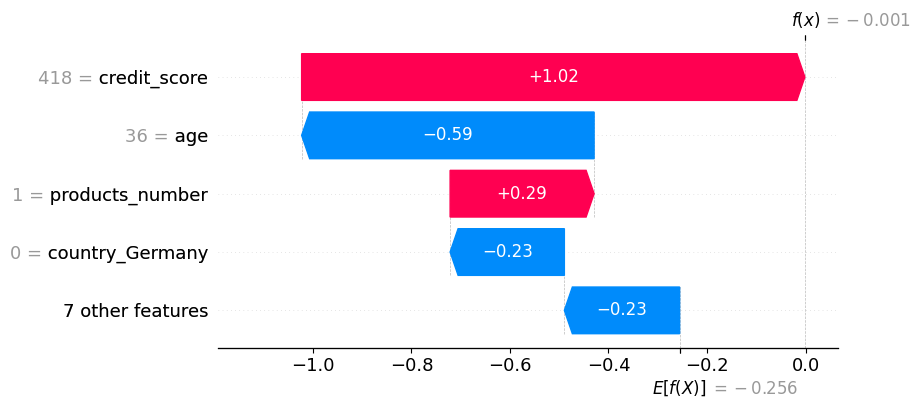

CORRECT PREDICTION
True value 0, predicted probab 0.02


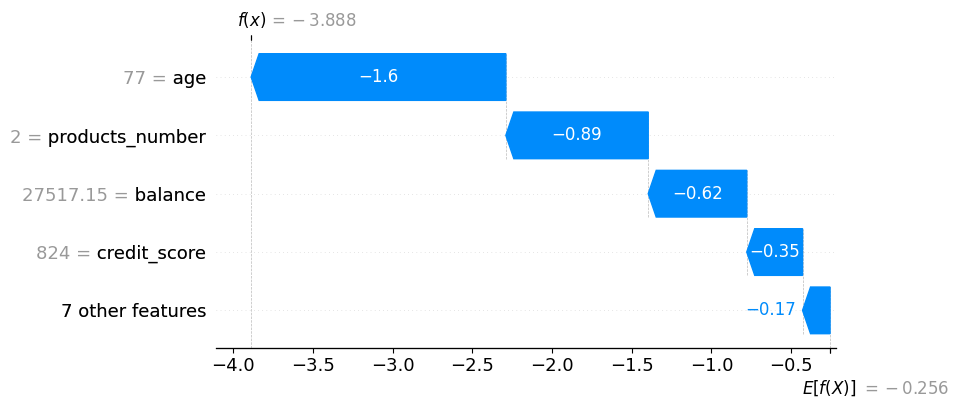

INCORRECT PREDICTION
True value 0, predicted probab 0.98


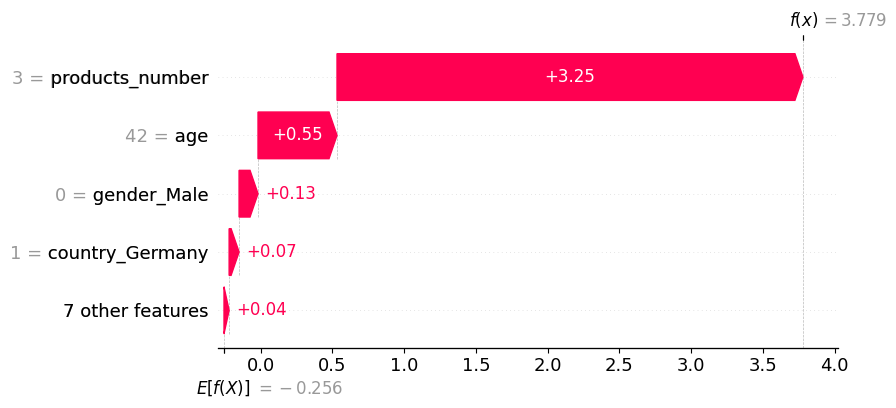

In [29]:
for i in selected_examples:
    if y_test.iloc[i] == all_predictions[i]:
        print('CORRECT PREDICTION')
    else:
        print('INCORRECT PREDICTION')
        
    print(f'True value {y_test.iloc[i]}, predicted probab {all_predicted_probabilities[i,1]:.2f}')
    
#     xi = xi[1]

    # SHAP waterfall plot - The waterfall plot is another local analysis plot of a single instance prediction.
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[i], 
            base_values=explainer.expected_value, 
            data=X_test_num.iloc[i],  
            feature_names=X_test_num.columns.tolist()
        ),
        max_display=5
    )

In [30]:
shap_values.shape

(3300, 11)

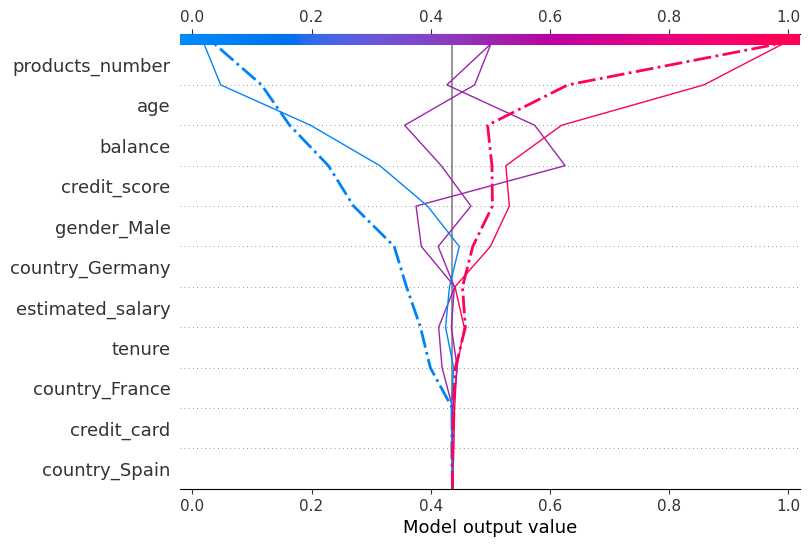

In [31]:
shap.decision_plot(explainer.expected_value, shap_values[selected_examples, :], X_test_num.columns, link="logit", ignore_warnings=True, highlight=[2,5])